# BillSum Summarization

## Load Dependencies

In [1]:
!pip uninstall -y flash-attn fsspec gcsfs transformers torch torchvision torchaudio
!pip install -q -U transformers accelerate bitsandbytes torch torchvision torchaudio datasets==2.14.6 fsspec==2023.9.2
!pip install -q -U rouge_score evaluate
!pip install -U sentence-transformers
!pip install bert_score

Found existing installation: fsspec 2025.3.0
Uninstalling fsspec-2025.3.0:
  Successfully uninstalled fsspec-2025.3.0
Found existing installation: gcsfs 2025.3.0
Uninstalling gcsfs-2025.3.0:
  Successfully uninstalled gcsfs-2025.3.0
Found existing installation: transformers 4.54.0
Uninstalling transformers-4.54.0:
  Successfully uninstalled transformers-4.54.0
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 15.9 MB/s

In [2]:
import datasets
from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration, AutoConfig
import evaluate
from tqdm import tqdm
import torch
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

## Load BillSum Dataset

In [3]:
from datasets import load_dataset, concatenate_datasets

billsum_train = datasets.load_dataset("billsum", split = "train")
billsum_test = datasets.load_dataset("billsum", split = "test")

combined = concatenate_datasets([billsum_train, billsum_test])

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [4]:
combined

Dataset({
    features: ['text', 'summary', 'title'],
    num_rows: 22218
})

In [5]:
a = [len(x) for x in combined["text"]]

In [6]:
print(min(a))
print(max(a))
print(sum(a) / len(a))

5001
19998
10271.888558826176


In [7]:
b = [len(x) for x in combined["summary"]]

print(min(b))
print(max(b))
print(sum(b) / len(b))

52
4995
1185.5058511117113


In [8]:
model_name = "google/pegasus-cnn_dailymail"

tokenizer = PegasusTokenizer.from_pretrained(model_name, from_pt=True)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [9]:
chunk_size = 22218
text_lengths = []

for record in tqdm(islice(combined, chunk_size), total = chunk_size):
  text_lengths.append(len(tokenizer(record["text"]).input_ids))

100%|██████████| 22218/22218 [02:54<00:00, 127.33it/s]


In [10]:
print(min(text_lengths))
print(max(text_lengths))
print(sum(text_lengths) / len(text_lengths))

247
10470
1763.635430731839


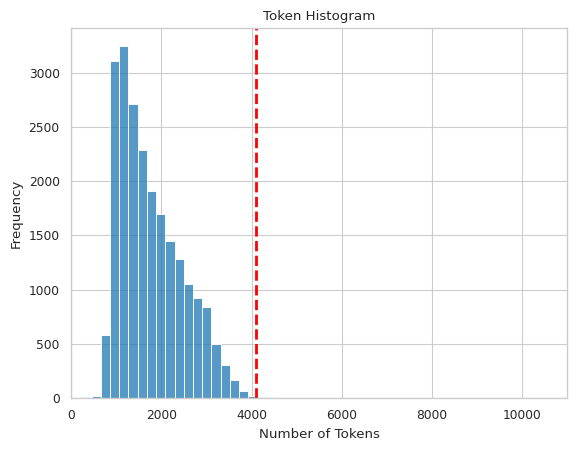

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("paper")
# Create histogram
sns.histplot(text_lengths, bins= 50)


# Show the plot
plt.title("Token Histogram")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.xlim(0, 11000)
plt.axvline(x=4096, color='red', linestyle='--', linewidth=2)

plt.show()

In [12]:
chunk_size = 22218
text_lengths = []

for record in tqdm(islice(combined, chunk_size), total = chunk_size):
  text_lengths.append(len(tokenizer(record["summary"]).input_ids))

print(min(text_lengths))
print(max(text_lengths))
print(sum(text_lengths) / len(text_lengths))

100%|██████████| 22218/22218 [00:31<00:00, 698.79it/s]

10
943
209.4521109010712


# Text Separation and Splitting

The following functions split a bill into its main numbered sections and then further splits them based off of each lettered subsection. We are not splitting by each sentence because the text formmatting makes it difficult to split it that way.

In [13]:
def split_bill_into_sections(text):
    # Normalize line breaks
    text = re.sub(r'\n+', '\n', text)

    # Ensure section headers start on a new line (case-insensitive)
    text = re.sub(r'(?<!\n)((SECTION|SEC)\.?\s*\d+\.)', r'\n\1', text, flags=re.IGNORECASE)

    # Match from each SECTION/SEC until the next one or end of text
    pattern = r'((?:SEC|SECTION)\.?\s*\d+\..*?)(?=(?:SEC|SECTION)\.?\s*\d+\.|\Z)'
    sections = re.findall(pattern, text, flags=re.DOTALL | re.IGNORECASE)

    if len(sections) == 0:
        return [text]

    return sections


def split_by_lettered_clause_with_linebreaks(text):
    # Insert a unique delimiter before (a), (b), ... only if they occur after a line break and spaces
    pattern = r'\n[ \t]*\([a-z]\)(?!\([a-zA-Z0-9]\))'
    split_text = re.split(f'({pattern})', text)

    # Recombine so that each clause includes its clause marker
    combined = []
    buffer = ''
    for part in split_text:
        if re.match(pattern, part):
            if buffer:
                combined.append(buffer.strip())
            buffer = part.lstrip('\n')
        else:
            buffer += part
    if buffer:
        combined.append(buffer.strip())

    res = [clause for clause in combined if clause]
    if res == []:
        return [text]
    return res


# Helper function for splitting the bill into subsections
def split_bill(text):
    sections = split_bill_into_sections(text)
    nested_list = [split_by_lettered_clause_with_linebreaks(section) for section in sections]
    flat_list = [item for sublist in nested_list for item in sublist]
    return list(dict.fromkeys(flat_list)) # Prevent duplicates

Below, we will check the average sentence length for each summary to determine the number of sentences to return in our extraction model.

In [14]:
def count_sentences(paragraph):
    # Split the paragraph into sentences using regex for '.', '!' or '?'
    sentences = re.split(r'[.!?]+', paragraph)
    # Remove empty strings and strip whitespace
    sentences = [s.strip() for s in sentences if s.strip()]
    return len(sentences)

In [15]:
# Get average sentence length
total = 0
for paragraph in billsum_test["summary"]:
    total += count_sentences(paragraph)

total / len(billsum_test["summary"])

5.599877638421535

# Cluster Based Extraction

Below is a function for cluster based extraction. For the vectorization of our sentences we are using tfidf.

In [16]:
def cluster_based_summary(sentences, num_clusters=3):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(sentences)

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(X)

    # Find closest sentence to each cluster centroid
    summary_sentences = []
    for i in range(num_clusters):
        cluster_center = kmeans.cluster_centers_[i]
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        cluster_vectors = X[cluster_indices].toarray()

        # Compute distances to centroid
        distances = np.linalg.norm(cluster_vectors - cluster_center, axis=1)
        closest_index = cluster_indices[np.argmin(distances)]
        summary_sentences.append(sentences[closest_index])

    # Sort by original order
    summary_sentences.sort(key=lambda s: sentences.index(s))

    return summary_sentences

Below we perform cluster based extraction on the first bill in the test dataset. We split the bill into subsections as mentioned above and defined eight cluters. The result is an eight sentence summary of the bill.

In [ ]:
# Example
test_split = split_bill(billsum_test[0]["text"])
cluster_based_summary(test_split, 6)

["(b) Manchester, New Hampshire.--Section 219(e)(3) of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended by striking ``$10,000,000'' and inserting ``$20,000,000''.",
 "SEC. 2. UPPER MISSISSIPPI RIVER ENVIRONMENTAL MANAGEMENT PROGRAM.\n    Section 1103(e)(5) of the Water Resources Development Act of 1986 \n(33 U.S.C. 652(e)(5)) (as amended by section 509(c)(3) of the Water \nResources Development Act of 1999 (113 Stat. 340)) is amended by \nstriking ``paragraph (1)(A)(i)'' and inserting ``paragraph (1)(B)''.",
 "SEC. 4. PROJECT REAUTHORIZATIONS.\n    Section 364 of the Water Resources Development Act of 1999 (113 \nStat. 313) is amended--\n        (1) by striking ``Each'' and all that follows through the colon \n    and inserting the following: ``Each of the following projects is \n    authorized to be carried out by the Secretary, and no construction \n    on any such project may be initiated until the Secretary determines \n    that the projec

The below function performs cluster based extraction on a list of paragraphs with a set number of clusters, returning a list of summaries.

In [ ]:
def do_cluster_based_summary(paragraphs, num_clusters=3):
    res = []
    for i in range(len(paragraphs)):
        paragraph = paragraphs[i]
        split = split_bill(paragraph)

        if len(split) < num_clusters:
            summary = cluster_based_summary(split, len(split))
        elif len(split) == num_clusters:
            summary = split
        else:
            summary = cluster_based_summary(split, num_clusters)

        processed_summary = " ".join(summary)
        res.append(processed_summary)

    return res

In [ ]:
billsum_test_list = [bill["text"] for bill in billsum_test]

test_cluster = do_cluster_based_summary(billsum_test_list, 6)
test_cluster[0]

"(b) Manchester, New Hampshire.--Section 219(e)(3) of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended by striking ``$10,000,000'' and inserting ``$20,000,000''. SEC. 2. UPPER MISSISSIPPI RIVER ENVIRONMENTAL MANAGEMENT PROGRAM.\n    Section 1103(e)(5) of the Water Resources Development Act of 1986 \n(33 U.S.C. 652(e)(5)) (as amended by section 509(c)(3) of the Water \nResources Development Act of 1999 (113 Stat. 340)) is amended by \nstriking ``paragraph (1)(A)(i)'' and inserting ``paragraph (1)(B)''. SEC. 4. PROJECT REAUTHORIZATIONS.\n    Section 364 of the Water Resources Development Act of 1999 (113 \nStat. 313) is amended--\n        (1) by striking ``Each'' and all that follows through the colon \n    and inserting the following: ``Each of the following projects is \n    authorized to be carried out by the Secretary, and no construction \n    on any such project may be initiated until the Secretary determines \n    that the project is tech

# Evaluation



Below is code to calculate the ROUGE score.

In [ ]:
rouge = evaluate.load('rouge')

predictions = test_cluster
references = [bill["summary"] for bill in billsum_test]

results = rouge.compute(predictions=predictions, references=references)
print(results)

NameError: name 'test_cluster' is not defined

Below is code to calculate the BERTScore. We calculate on the first 100 bills because collab runs out of RAM and crashes.

In [ ]:
bertscore = evaluate.load("bertscore")

predictions = test_cluster[:100] # first 100 summaries
references = [bill["summary"] for bill in billsum_test][:100]

results = bertscore.compute(predictions=predictions, references=references, lang="en")
print(results)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.7628177404403687, 0.7304336428642273, 0.8295908570289612, 0.6889331936836243, 0.7449243664741516, 0.7163012623786926, 0.7394254207611084, 0.7073666453361511, 0.7162339687347412, 0.7191856503486633, 0.6808777451515198, 0.7735979557037354, 0.6924551725387573, 0.755813479423523, 0.7150624990463257, 0.7481931447982788, 0.6541436910629272, 0.7408742904663086, 0.808912992477417, 0.716727077960968, 0.7985923290252686, 0.7357447147369385, 0.8232971429824829, 0.7855857610702515, 0.7067907452583313, 0.7721643447875977, 0.7649704217910767, 0.7493829727172852, 0.6385793089866638, 0.7596798539161682, 0.7042134404182434, 0.7238054275512695, 0.7147765755653381, 0.6956804394721985, 0.7759206295013428, 0.7035062313079834, 0.7089588046073914, 0.7812849879264832, 0.76091468334198, 0.7290829420089722, 0.7472823858261108, 0.8080883622169495, 0.6522113680839539, 0.6775892376899719, 0.7663837671279907, 0.6937090158462524, 0.7232735753059387, 0.7625541090965271, 0.7845306992530823, 0.74132430

In [ ]:
print(f'Average precision: {np.mean(results["precision"])}')
print(f'Average recall: {np.mean(results["recall"])}')
print(f'Average f1: {np.mean(results["f1"])}')

Average precision: 0.7380945700407028
Average recall: 0.8430766206979752
Average f1: 0.786375070810318


# Maximal Marginal Relevance

Below is a function for maximal marginal relevance. For the vectorization of our sentences we are using tfidf.

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def mmr_summary(sentences, top_n=3, lambda_param=0.7):
    vectorizer = TfidfVectorizer(stop_words='english')
    sentence_vectors = vectorizer.fit_transform(sentences)
    similarity_matrix = cosine_similarity(sentence_vectors)

    selected_indices = [0]  # Start with the first sentence
    candidates = list(range(1, len(sentences)))

    while len(selected_indices) < top_n and candidates:
        mmr_scores = []

        for idx in candidates:
            relevance = similarity_matrix[0][idx]  # relevance to first sentence (or centroid)
            redundancy = max(similarity_matrix[idx][j] for j in selected_indices)

            mmr_score = lambda_param * relevance - (1 - lambda_param) * redundancy
            mmr_scores.append((idx, mmr_score))

        # Select the index with the highest MMR score
        best_idx = max(mmr_scores, key=lambda x: x[1])[0]
        selected_indices.append(best_idx)
        candidates.remove(best_idx)

    return [sentences[i] for i in selected_indices]

The below function performs mmr summarization on a list of paragraphs with a set number for top_n, returning a list of summaries.

In [23]:
def do_mmr_summary(paragraphs, top_n=3, lambda_param=0.7):
    res = []
    for i in range(len(paragraphs)):
        paragraph = paragraphs[i]
        split = split_bill(paragraph)

        if len(split) < top_n:
            summary = mmr_summary(split, len(split), lambda_param)
        else:
            summary = mmr_summary(split, top_n, lambda_param)

        processed_summary = " ".join(summary)
        res.append(processed_summary)

    return res

In [ ]:
billsum_test_list = [bill["text"] for bill in billsum_test]

test_mmr = do_mmr_summary(billsum_test_list, 6, 0.7)
test_mmr[0]

"SECTION 1. ENVIRONMENTAL INFRASTRUCTURE. SEC. 2. UPPER MISSISSIPPI RIVER ENVIRONMENTAL MANAGEMENT PROGRAM.\n    Section 1103(e)(5) of the Water Resources Development Act of 1986 \n(33 U.S.C. 652(e)(5)) (as amended by section 509(c)(3) of the Water \nResources Development Act of 1999 (113 Stat. 340)) is amended by \nstriking ``paragraph (1)(A)(i)'' and inserting ``paragraph (1)(B)''. (b) Authorization of Appropriations.--Funds are hereby authorized \nto be appropriated for the Department of Transportation for the program \nauthorized in subsection (a) in amounts as follows:\n        (1) Fiscal year 2000.--For fiscal year 2000, $10,000,000.\n        (2) Fiscal year 2001.--For fiscal year 2001, $10,000,000.\n        (3) Fiscal year 2002.--For fiscal year 2002, $7,000,000. SEC. 8. CONTINUATION OF SUBMISSION OF CERTAIN REPORTS BY THE SECRETARY \n              OF THE ARMY. (c) Applicability.--The program referred to in subsection (a) is \nthe program for which funds appropriated in title I 

# Evaluation

Below is code to calculate the ROUGE score.

In [ ]:
rouge = evaluate.load('rouge')

predictions = test_mmr
references = [bill["summary"] for bill in billsum_test]

results = rouge.compute(predictions=predictions, references=references)
print(results)

{'rouge1': np.float64(0.31178465198111616), 'rouge2': np.float64(0.17293117102393665), 'rougeL': np.float64(0.20109383442867385), 'rougeLsum': np.float64(0.2749335612091709)}


Below is code to calculate the BERTScore. We calculate on the first 100 bills because collab runs out of RAM and crashes.

In [ ]:
bertscore = evaluate.load("bertscore")

predictions = test_mmr[:100] # first 100 summaries
references = [bill["summary"] for bill in billsum_test][:100]

results = bertscore.compute(predictions=predictions, references=references, lang="en")
print(results)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.7324951887130737, 0.7419546842575073, 0.750971794128418, 0.6613007187843323, 0.7232439517974854, 0.7244513630867004, 0.7359369993209839, 0.6908872127532959, 0.707358181476593, 0.6790696382522583, 0.7343772649765015, 0.8061306476593018, 0.6992443799972534, 0.7703390121459961, 0.709174394607544, 0.7938467264175415, 0.7002288103103638, 0.7389391660690308, 0.8296598792076111, 0.7032503485679626, 0.7990117073059082, 0.7701781988143921, 0.8227806091308594, 0.7941527366638184, 0.7162835597991943, 0.7254822254180908, 0.7877998948097229, 0.7226470708847046, 0.7034810185432434, 0.7661150693893433, 0.7328222393989563, 0.8142343163490295, 0.7508277893066406, 0.7197351455688477, 0.7651640772819519, 0.7035062313079834, 0.7043972015380859, 0.7940505743026733, 0.7984535098075867, 0.7143920660018921, 0.7365447282791138, 0.7766216397285461, 0.7366915941238403, 0.7137800455093384, 0.7646762132644653, 0.6961846351623535, 0.7362000942230225, 0.8011077642440796, 0.770587682723999, 0.6602002

In [ ]:
print(f'Average precision: {np.mean(results["precision"])}')
print(f'Average recall: {np.mean(results["recall"])}')
print(f'Average f1: {np.mean(results["f1"])}')

Average precision: 0.7438458973169326
Average recall: 0.8429671907424927
Average f1: 0.7895400428771973


# Hybrid Cluster Extraction + PEGASUS

The below function creates a dataset with shortened bills using MMR summarization, to avoid truncation when the bills get passed through PEGASUS.

In [24]:
def get_mmr_summary_as_dataset(dataset, top_n=3, lambda_param=0.7):
    sentences = [bill["text"] for bill in dataset]
    summaries = [bill["summary"] for bill in dataset]

    cluster_summaries = do_mmr_summary(sentences, top_n, lambda_param)

    res = {"text": cluster_summaries, "summary": summaries}
    return datasets.Dataset.from_dict(res)

In [25]:
shortened_billsum_train = get_mmr_summary_as_dataset(billsum_train, 6)
shortened_billsum_test = get_mmr_summary_as_dataset(billsum_test, 6)

### Check Max Sequence Length

PEGASUS has a maximum sequence length of 1028. We can tokenize a subset of the training data to check how many documents will be truncated.

In [17]:
model_name = "google/pegasus-cnn_dailymail"

tokenizer = PegasusTokenizer.from_pretrained(model_name, from_pt=True)

In [26]:
shortened_billsum_test

Dataset({
    features: ['text', 'summary'],
    num_rows: 3269
})

In [27]:
chunk_size = 3269
text_lengths = []

for record in tqdm(islice(shortened_billsum_train, chunk_size), total = chunk_size):
  text_lengths.append(len(tokenizer(record["text"]).input_ids))

100%|██████████| 3269/3269 [00:15<00:00, 217.48it/s]


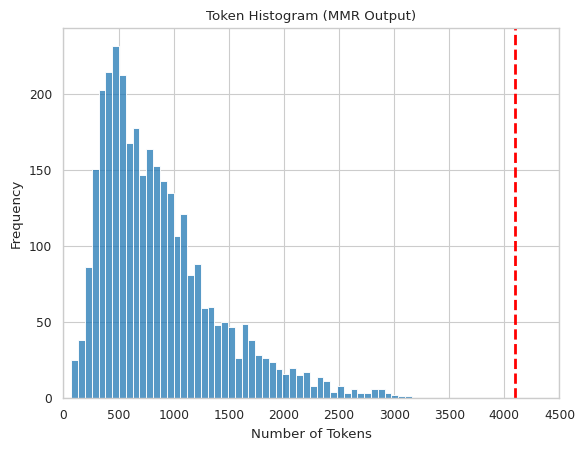

In [28]:
sns.set_style("whitegrid")
sns.set_context("paper")
sns.histplot(text_lengths, bins= 50)


# Show the plot
plt.title("Token Histogram (MMR Output)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.xlim(0, 4500)
plt.axvline(x=4096, color='red', linestyle='--', linewidth=2)

plt.show()

## Load PEGASUS Model

In [ ]:
model = TFPegasusForConditionalGeneration.from_pretrained(model_name, from_pt=True)
config = AutoConfig.from_pretrained(model_name)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFPegasusForConditionalGeneration.

Some weights or buffers of the TF 2.0 model TFPegasusForConditionalGeneration were not initialized from the PyTorch model and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_pegasus_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFPegasusMainLayer)  multiple                  570797056 
                                                                 
 final_logits_bias (BiasLay  multiple                  96103     
 er)                                                             
                                                                 
Total params: 570893159 (2.13 GB)
Trainable params: 570797056 (2.13 GB)
Non-trainable params: 96103 (375.40 KB)
_________________________________________________________________


## Test Base PEGASUS Without Fine Tuning

Below we create a dataset of the first 5 documents in the shortened billsum dataset, due to our compute limitations on Colab.

In [ ]:
mini_billsum_test = {"text": shortened_billsum_test["text"][:5], "summary": shortened_billsum_test["summary"][:5]}
mini_billsum_test = datasets.Dataset.from_dict(mini_billsum_test)

In [ ]:
def process_batch(batch):
  inputs = tokenizer(batch["text"], truncation = True, padding = "longest", return_tensors = "tf")
  return inputs, batch["summary"]

def generate_summaries(data, batch_size = 16):
  generated_summaries = []

  for i in tqdm(range(0, len(data), batch_size)):
    inputs, targets = process_batch(data[i:i+batch_size])

    output = model.generate(
      input_ids=inputs["input_ids"],
      attention_mask=inputs["attention_mask"],
      max_length=512,         # Increase as needed, up to model limits
      min_length=128,
      length_penalty=0.5,     # Lower value encourages longer output
      num_beams=4,
      early_stopping=True,
      repetition_penalty=1.2,        # <--- Penalizes repeating tokens
      no_repeat_ngram_size=3,
    )



    generated_summaries += tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=False)

  return generated_summaries

In [ ]:
test_summaries_base = generate_summaries(mini_billsum_test, 1)

100%|██████████| 5/5 [08:55<00:00, 107.02s/it]


In [ ]:
test_summaries_base

["Funds are authorized for the program in amounts as follows: fiscal years 2000 and 2001 .<n>Funds are available for obligation upon the enactment of legislation authorizing the program.<n>The Secretary of the Army will provide a description of the program and a list of recommended improvements to the U.S. Environmental Protection Agency's website at: http://www. EPA.gov/EPA/EPA-Grants/Grants.asp?GrantType=Water- Resources-Development-Program.<n>This bill is signed into law by the President of the United States. To learn more about this bill, go to: www.house.gov.",
 'The fee shall apply to all authorized Federal AUMs under the jurisdiction of the Department of Agriculture and the United States Department of the Interior .<n>All grazing operations conducted on any Federal lands shall be subject to all applicable Federal, State, and local laws, including but not limited to, Animal Damage Control Act, Clean Air Act, Endangered Species Act, Federal Insecticide, Fungicide, and Rodenticide 

Below we calcualate the ROUGE score.

In [ ]:
rouge = evaluate.load('rouge')

predictions = test_summaries_base
references = [bill["summary"] for bill in billsum_test][:5]

results = rouge.compute(predictions=predictions, references=references)
print(results)

{'rouge1': np.float64(0.3623121968019421), 'rouge2': np.float64(0.1571292434960835), 'rougeL': np.float64(0.208760228938474), 'rougeLsum': np.float64(0.23106275732795895)}


Below is code to calculate the BERTScore.

In [ ]:
bertscore = evaluate.load("bertscore")

predictions = test_summaries_base # first 100 summaries
references = [bill["summary"] for bill in billsum_test][:5]

results = bertscore.compute(predictions=predictions, references=references, lang="en")
print(results)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.8159435987472534, 0.8304285407066345, 0.8418240547180176, 0.8099534511566162, 0.8528257608413696], 'recall': [0.7882291078567505, 0.890090823173523, 0.8616036772727966, 0.8245987892150879, 0.8458019495010376], 'f1': [0.801846981048584, 0.8592252731323242, 0.8515990376472473, 0.8172104954719543, 0.8492993712425232], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.53.2)'}


In [ ]:
print(f'Average precision: {np.mean(results["precision"])}')
print(f'Average recall: {np.mean(results["recall"])}')
print(f'Average f1: {np.mean(results["f1"])}')

Average precision: 0.8301950812339782
Average recall: 0.8420648694038391
Average f1: 0.8358362317085266
